# Исследование регионов для выбора места разработки

## Порядок выполнения проекта
- Загрузить и подготовить данные. Пояснить порядок действий.
- Обучить и проверить модель для каждого региона:
 - 2.1. Разбить данные на обучающую и валидационную выборки в соотношении 75:25.
 - 2.2. Обучить модель и сделать предсказания на валидационной выборке.
 - 2.3. Сохранить предсказания и правильные ответы на валидационной выборке.
 - 2.4. Напечатать на экране средний запас предсказанного сырья и RMSE модели.
 - 2.5. Проанализировать результаты.
- Подготовиться к расчёту прибыли:
 - 3.1. Все ключевые значения для расчётов сохранить в отдельных переменных.
 - 3.2. Рассчитать достаточный объём сырья для безубыточной разработки новой скважины. Сравнить полученный объём сырья со средним запасом в каждом регионе.
 - 3.3. Написать выводы по этапу подготовки расчёта прибыли.
- Написать функцию для расчёта прибыли по выбранным скважинам и предсказаниям модели:
 - 4.1. Выбрать скважины с максимальными значениями предсказаний. Количество скважин зависит от бюджета компании и стоимости разработки одной скважины.
 - 4.2. Просуммировать целевое значение объёма сырья, соответствующее этим предсказаниям.
 - 4.3. Рассчитать прибыль для полученного объёма сырья.
- Посчитать риски и прибыль для каждого региона:
 - 5.1. Применить технику Bootstrap с 1000 выборок, чтобы найти распределение прибыли.
 - 5.2. Найти среднюю прибыль, 95%-й доверительный интервал и риск убытков. Убыток — это отрицательная прибыль.
 - 5.3. Написать выводы: предложить регион для разработки скважин и обосновать выбор.

## Описание данных
Данные геологоразведки трёх регионов находятся в файлах:
* geo_data_0.csv, geo_data_1.csv, geo_data_2.csv
    * id — уникальный идентификатор скважины (точки);
    * f0, f1, f2 — три признака точек (неважно, что они означают, но сами признаки значимы);
    * product — объём запасов в скважине (тыс. баррелей).

# 1. Загрузка и подготовка данных

In [1]:
#1
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

#2
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import cross_val_score
from sklearn.metrics import mean_squared_error

#5
from numpy.random import RandomState

Откроем файлы с данными и изучим общую информацию.

In [2]:
geo_data_0 = pd.read_csv('/datasets/geo_data_0.csv')
geo_data_1 = pd.read_csv('/datasets/geo_data_1.csv')
geo_data_2 = pd.read_csv('/datasets/geo_data_2.csv')

In [3]:
#округляем значения до сотых при отображении в выводе дробных чисел
pd.options.display.float_format = '{:,.2f}'.format

Регион 0 :
--------------
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 5 columns):
 #   Column   Non-Null Count   Dtype  
---  ------   --------------   -----  
 0   id       100000 non-null  object 
 1   f0       100000 non-null  float64
 2   f1       100000 non-null  float64
 3   f2       100000 non-null  float64
 4   product  100000 non-null  float64
dtypes: float64(4), object(1)
memory usage: 3.8+ MB
None
      id    f0    f1   f2  product
0  txEyH  0.71 -0.50 1.22   105.28
1  2acmU  1.33 -0.34 4.37    73.04
2  409Wp  1.02  0.15 1.42    85.27
3  iJLyR -0.03  0.14 2.98   168.62
4  Xdl7t  1.99  0.16 4.75   154.04
Дубликаты строк: 0
--------------
Регион 1 :
--------------
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 5 columns):
 #   Column   Non-Null Count   Dtype  
---  ------   --------------   -----  
 0   id       100000 non-null  object 
 1   f0       100000 non-null  float64


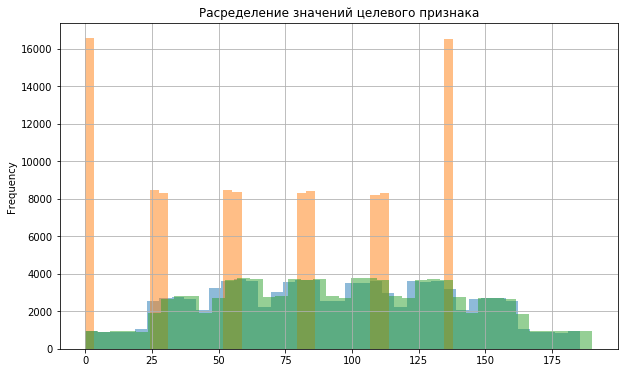

In [4]:
regions = [geo_data_0, geo_data_1, geo_data_2]
i = 0
for reg in regions:
    print('Регион', i, ':')
    print('--------------')
    print(reg.info())
    print(reg.head())
    print('Дубликаты строк:', reg.duplicated().sum())
    print('--------------')
    reg['product'].plot(kind='hist', bins=40, alpha=0.5, grid=True, figsize=(10, 6), \
                        title = 'Расределение значений целевого признака')
    i += 1
plt.show()
    

Данные:
* не содержат пропусков;
* категориальный признак id записан смесью цифр и символов английского алфавита;
* количественные признаки f0, f1, f2 и product - числа с плавающей точкой;
* значения целевого признака для региона с id 1 имеют чётко выраженные группы. 

Признак id никак не должен повлиять на принятие алгоритмом решения, поэтому его необходимо удалить.

In [5]:
geo_data_0 = geo_data_0.drop(['id'], axis=1)
geo_data_1 = geo_data_1.drop(['id'], axis=1)
geo_data_2 = geo_data_2.drop(['id'], axis=1)
geo_data_2.head()

,f0,f1,f2,product
0,-1.15,0.96,-0.83,27.76
1,0.26,0.27,-2.53,56.07
2,0.19,0.29,-5.59,62.87
3,2.24,-0.55,0.93,114.57
4,-0.52,1.72,5.90,149.60


# Вывод

Для таблиц по каждому из регионов характерно следующее:
    - нет дубликатов,
    - нет пропусков данных,
    - id - набор символов,
    - прочие параметры - числа с плавающей точкой, как положительные, так и отрицательные,
    - значения целевого признака в одном из регионов имеют чётко выраженные группы.
    
Признак id удалён.

Данные готовы для дальнейшего использования.

# 2. Обучение и проверка модели

## Обучить и проверить модель для каждого региона:
### Разбить данные на обучающую и валидационную выборки в соотношении 75:25
 

In [6]:
state = 28

geo_0_tr, geo_0_val = train_test_split(geo_data_0, test_size=0.25, random_state = state)
geo_1_tr, geo_1_val = train_test_split(geo_data_1, test_size=0.25, random_state = state)
geo_2_tr, geo_2_val = train_test_split(geo_data_2, test_size=0.25, random_state = state)
print('Размеры выборки. Обучающая:', len(geo_0_tr), ' , валидационная:', len(geo_0_val))

Размеры выборки. Обучающая: 75000  , валидационная: 25000


Для проверки, можно ли использовать одну и ту же модель на всех регионах, сделаем альтернативную обучающую выборку. Для этого возьмём случайным образом треть данных из объединнённой по всем трём регионам.

Размеры выборки. Обучающая: 75000  , обучающая (целевые признаки): 75000


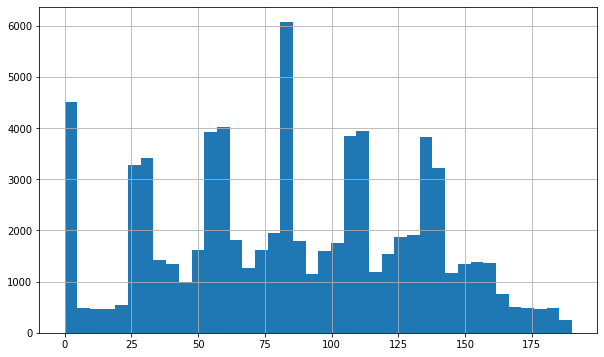

In [7]:
train = pd.concat([geo_0_tr, geo_1_tr, geo_2_tr]).sample(n = len(geo_0_tr), \
                                                                  random_state = state, replace=False)
train_target = train['product']
train_features = train.drop(['product'], axis=1)
print('Размеры выборки. Обучающая:', len(train_features), ' , обучающая (целевые признаки):', len(train_target))
train_target.hist(bins=40, figsize=(10, 6))

Выделим целевой признак для обучающих и валидационных выборок по регионам.

In [8]:
geo_0_target_tr = geo_0_tr['product']
geo_0_tr = geo_0_tr.drop(['product'], axis=1)

geo_1_target_tr = geo_1_tr['product']
geo_1_tr = geo_1_tr.drop(['product'], axis=1)

geo_2_target_tr = geo_2_tr['product']
geo_2_tr = geo_2_tr.drop(['product'], axis=1)

geo_0_target_val = geo_0_val['product']
geo_0_val = geo_0_val.drop(['product'], axis=1)

geo_1_target_val = geo_1_val['product']
geo_1_val = geo_1_val.drop(['product'], axis=1)

geo_2_target_val = geo_2_val['product']
geo_2_val = geo_2_val.drop(['product'], axis=1)


In [9]:
print('Размеры выборки. Обучающая:', len(geo_0_tr), ' , обучающая (целевые признаки):', len(geo_0_target_tr), \
      'валидационная:', len(geo_0_val), ', валидационная (целевые признаки):', len(geo_0_target_val))

Размеры выборки. Обучающая: 75000  , обучающая (целевые признаки): 75000 валидационная: 25000 , валидационная (целевые признаки): 25000


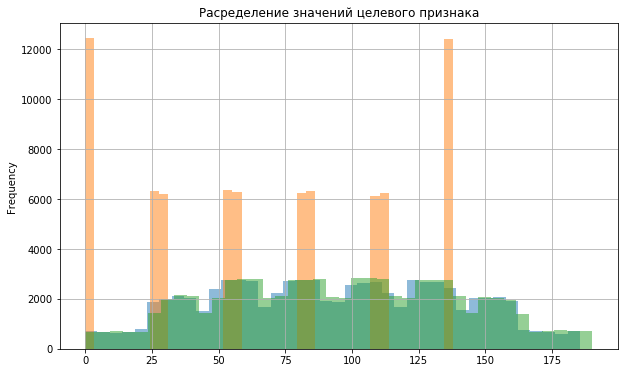

In [10]:
geo_0_target_tr.plot(kind='hist', bins=40, alpha=0.5, grid=True, figsize=(10, 6), \
                        title = 'Расределение значений целевого признака')
geo_1_target_tr.plot(kind='hist', bins=40, alpha=0.5, grid=True, figsize=(10, 6), \
                        title = 'Расределение значений целевого признака')
geo_2_target_tr.plot(kind='hist', bins=40, alpha=0.5, grid=True, figsize=(10, 6), \
                        title = 'Расределение значений целевого признака')

Полученные тестовые выборки по форме похожи на совмещённые данные по всем регионам.

### Обучить модель и сделать предсказания на валидационной выборке. Сохранить предсказания и правильные ответы на валидационной выборке. Напечатать на экране средний запас предсказанного сырья и RMSE модели

По условиям задачи для обучения модели подходит только линейная регрессия (остальные — недостаточно предсказуемые).
**Модель 0.** Обучение на объединённой выборке.

In [11]:
model = LinearRegression()
final_score = cross_val_score(model, train_features, train_target, cv=5).sum() / 5
model.fit(train_features, train_target)

total_predict = pd.DataFrame(columns=['fact', 'predict', 'rmse'])

def region_predict(reg_name, geo_val, geo_target_val):
    predicted_valid = model.predict(geo_val)
    mse = mean_squared_error(geo_target_val, predicted_valid)
    total_predict.loc[reg_name, 'fact'] = geo_target_val.mean()
    total_predict.loc[reg_name, 'predict'] = predicted_valid.mean()
    total_predict.loc[reg_name, 'rmse'] = mse ** 0.5
    print(reg_name, ': ', model.score(geo_val, geo_target_val))
    
    return

final_score

0.3029914214497064

In [12]:
#результаты предсказаний по регионам

region_predict(0, geo_0_val, geo_0_target_val)
region_predict(1, geo_1_val, geo_1_target_val)
region_predict(2, geo_2_val, geo_2_target_val)
total_predict

0 :  0.19674126495234634
1 :  0.4315515714441077
2 :  0.12680458147171292


,fact,predict,rmse
0,92.43,88.48,39.64
1,68.67,79.45,34.61
2,94.74,87.79,41.74


Для обучения модели использовалась объединённая выборка по трём регионам. 

В результате значительно меньшее RMSE у региона 1, там же и значение R2 больше. Модель лучше предсказывает данные, в регионе, где имеется чёткое разделение значений целевого признака по группам.

Попробуем построить альтернативные модели.

**Модель 1.** Для каждого региона модель обучается только на собственных данных.

In [13]:
print('Размеры выборки. Обучающая:', len(geo_0_tr), ' , обучающая (целевые признаки):', len(geo_0_target_tr), \
      'валидационная:', len(geo_0_val), ', валидационная (целевые признаки):', len(geo_0_target_val))


model = LinearRegression()

def region_predict1(reg_name, geo_tr, geo_target_tr, geo_val, geo_target_val):
    model.fit(geo_tr, geo_target_tr)
    predicted_valid = model.predict(geo_val)
    mse = mean_squared_error(geo_target_val, predicted_valid)
    total_predict.loc[reg_name, 'fact'] = geo_target_val.mean()
    total_predict.loc[reg_name, 'predict'] = predicted_valid.mean()
    total_predict.loc[reg_name, 'rmse'] = mse ** 0.5
    print(reg_name, ': ', model.score(geo_val, geo_target_val))
    return

region_predict1(3, geo_0_tr, geo_0_target_tr, geo_0_val, geo_0_target_val)
region_predict1(4, geo_1_tr, geo_1_target_tr, geo_1_val, geo_1_target_val)
region_predict1(5, geo_2_tr, geo_2_target_tr, geo_2_val, geo_2_target_val)

total_predict

Размеры выборки. Обучающая: 75000  , обучающая (целевые признаки): 75000 валидационная: 25000 , валидационная (целевые признаки): 25000
3 :  0.27332124901685595
4 :  0.9996234156340127
5 :  0.1981755867277667


,fact,predict,rmse
0,92.43,88.48,39.64
1,68.67,79.45,34.61
2,94.74,87.79,41.74
3,92.43,92.44,37.70
4,68.67,68.68,0.89
5,94.74,94.70,40.00


Значение RMSE сократилось. Причём, для региона 1 сократилось весьма значительно, а точность этой модели стала составлять почти 100%.

Для двух других регионов точность повысилась, уменьшился RMSE, но в меньшей степени.

**Модель 2.** Обучим модель только на данных региона 1.

In [14]:
model = LinearRegression()
model.fit(geo_1_tr, geo_1_target_tr)
    
def region_predict2(reg_name, geo_val, geo_target_val):
    predicted_valid = model.predict(geo_val)
    mse = mean_squared_error(geo_target_val, predicted_valid)
    total_predict.loc[reg_name, 'fact'] = geo_target_val.mean()
    total_predict.loc[reg_name, 'predict'] = predicted_valid.mean()
    total_predict.loc[reg_name, 'rmse'] = mse ** 0.5
    print(reg_name, ': ', model.score(geo_val, geo_target_val))
    return

region_predict2(6, geo_0_val, geo_0_target_val)
region_predict2(7, geo_1_val, geo_1_target_val)
region_predict2(8, geo_2_val, geo_2_target_val)

total_predict

6 :  -2.261061456897505
7 :  0.9996234156340127
8 :  -2.86290955354289


,fact,predict,rmse
0,92.43,88.48,39.64
1,68.67,79.45,34.61
2,94.74,87.79,41.74
3,92.43,92.44,37.70
4,68.67,68.68,0.89
5,94.74,94.70,40.00
6,92.43,68.84,79.87
7,68.67,68.68,0.89
8,94.74,67.53,87.80


Значение RMSE осталось прежним для региона 1, для остальных - значительно повысилось. 

Для дальнейшей работы оставляем первую модель (для каждого региона модель обучается на своих данных). Высокое качество предсказаний и меньший квадратный корень из средней квадратичной ошибки в регионе 1 обусловлен самими данными этого региона.

In [15]:
total_predict = total_predict.loc[3:5].copy()
total_predict = total_predict.dropna().reset_index(drop=True)
total_predict

,fact,predict,rmse
0,92.43,92.44,37.70
1,68.67,68.68,0.89
2,94.74,94.70,40.00


In [16]:
model_0 = LinearRegression()
model_1 = LinearRegression()
model_2 = LinearRegression()

model_0.fit(geo_0_tr, geo_0_target_tr)
model_1.fit(geo_1_tr, geo_1_target_tr)
model_2.fit(geo_2_tr, geo_2_target_tr)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)

# Вывод

Для обучения используем для каждого региона свою выборку.

# 3. Подготовка к расчёту прибыли

## Все ключевые значения для расчётов сохранить в отдельных переменных

Для расчёта достаточного объёма сырья для безубыточной работы скважины разделим объём инвестиций на стоимость продукции и количество планируемых скважин.

In [17]:
# Объём инвестиций (тыс. руб.)
INVESTMENTS = 10000000

# Цена за единицу продукции (тыс. руб.)
PROD_PRICE = 450

# Количество рассматриваемых вышек в регионе
TOTAL_POINTS = 500

# Количество разрабатываемых вышек в регионе
POINTS = 200

#Максимально допустимая вероятность убытков
LOSS = 0.025

## Рассчитать достаточный объём сырья для безубыточной разработки новой скважины

In [18]:
min_prod = INVESTMENTS / (PROD_PRICE * POINTS)
print('Достаточный объём для безубыточной разработки скважины: {:.2f}'.format(min_prod))

Достаточный объём для безубыточной разработки скважины: 111.11


## Сравнить полученный объём сырья со средним запасом в каждом регионе

Посмотрим на вероятную вероятную прибыль по трём регионам на осовании среднего предсказанного объёма сырья.

In [19]:
# Предсказанная выручка 
total_predict['plus'] = PROD_PRICE * total_predict['predict'] * POINTS

# Предсказанный доход
total_predict['diff'] = total_predict['plus'] - INVESTMENTS

# Предсказанные затраты на инвестиции
total_predict['roi'] = total_predict['diff'] / INVESTMENTS

total_predict

,fact,predict,rmse,plus,diff,roi
0,92.43,92.44,37.70,"8,319,457.73","-1,680,542.27",-0.17
1,68.67,68.68,0.89,"6,180,848.22","-3,819,151.78",-0.38
2,94.74,94.70,40.00,"8,522,592.35","-1,477,407.65",-0.15


# Вывод

Предсказанный средний объём сырья в регионах от 68.68 до 94.70. Для безубыточной работы в одной скважине должно быть не менее 111.11 сырья.

Согласно усреднённым предсказаниям в зависимости от региона не окупится от 15 до 38 процентов вложений.

Однако данные усреднённые, значит, по факту могут быть точки со значительно большим количеством сырья.

# 4. Расчёт прибыли 
## Напиcать функцию для расчёта прибыли по выбранным скважинам и предсказаниям модели
### Выбрать скважины с максимальными значениями предсказаний (количество скважин зависит от бюджета компании и стоимости разработки одной скважины)
### Просуммировать целевое значение объёма сырья, соответствующее этим предсказаниям
### Рассчитать прибыль для полученного объёма сырья

Выберем для каждого региона случайным образом 500 точек для исследования.

In [20]:
region_0_choice = geo_data_0.sample(n = 500, random_state = state, replace=False, axis = 0)
region_1_choice = geo_data_1.sample(n = 500, random_state = state, replace=False, axis = 0)
region_2_choice = geo_data_2.sample(n = 500, random_state = state, replace=False, axis = 0)

region_0_choice_features = region_0_choice.drop(['product'], axis=1)
region_0_target = region_0_choice['product']

region_1_choice_features = region_1_choice.drop(['product'], axis=1)
region_1_target = region_1_choice['product']

region_2_choice_features = region_2_choice.drop(['product'], axis=1)
region_2_target = region_2_choice['product']

Предскажем значения целевого признака.

In [21]:
region_0_predict = model_0.predict(region_0_choice_features)
region_1_predict = model_1.predict(region_1_choice_features)
region_2_predict = model_2.predict(region_2_choice_features)

Найдём прибыль.

In [22]:
def region_profit (region_choice, region_predict):
    region_choice['predict'] = region_predict
    region_choice = region_choice.sort_values(by='predict', ascending = False).head(200)
    return (region_choice['product'].sum() * PROD_PRICE - INVESTMENTS)

In [23]:
print('Прибыль региона 0: {:.2f}'.format(region_profit(region_0_choice, region_0_predict)))
print('Прибыль региона 1: {:.2f}'.format(region_profit(region_1_choice, region_1_predict)))
print('Прибыль региона 2: {:.2f}'.format(region_profit(region_2_choice, region_2_predict)))

Прибыль региона 0: 73519.10
Прибыль региона 1: 356396.62
Прибыль региона 2: 453476.55


# Вывод

Для каждого региона из полного набора данных было отобрано случайным образом по 500 точек. Обученные для каждого региона модели выполнили предсказания.

Написана функция, отбирающая из 500 - 200 точек с наибольшими предсказаниями и возвращающая прибыль.

По факту на основании выбранных точек все три региона оказались доходными.

# 5. Расчёт рисков 

## Посчитать риски и прибыль для каждого региона
### Применить технику Bootstrap с 1000 выборок, чтобы найти распределение прибыли

### Найти среднюю прибыль, 95%-й доверительный интервал и риск убытков (убыток — это отрицательная прибыль)
Вероятность того, что отобранные точки не принесут достаточной прибыли.

In [24]:
rnd_state = RandomState(28)

Для каждого региона найдём среднее значение прибыли, 95%-й доверительный интервал и оценим долю отрицательных значений прибыли.

Для 95%-й доверительного интервала границы: нижняя - 2.5%-квантиль, верхняя - 97.5%-квантиль.

In [25]:
regions = [geo_data_0, geo_data_1, geo_data_2]

mean_result = pd.DataFrame(columns=['lower', 'upper', 'mean', 'risks'])

num = 0
for reg in regions:

    values = []
    risk_count = 0
    for i in range(1000):
        region_choice = reg.sample(n = TOTAL_POINTS, random_state = rnd_state, replace=False, axis = 0)
        region_choice_features = region_choice.drop(['product'], axis=1)
        region_target = region_choice['product']
        
        if num == 0:
            predictions = model_0.predict(region_choice_features)
        elif num == 1:
            predictions = model_1.predict(region_choice_features)
        else:
            predictions = model_2.predict(region_choice_features)
        
        profit = region_profit(region_choice, predictions)
        
        values.append(profit)
        
        if profit < 0:
            risk_count += 1
    values = pd.Series(values)

    reg_mean = values.mean()

    lower = values.quantile(0.025)
    upper = values.quantile(0.975)

    mean_result.loc[num, 'lower'] = lower
    mean_result.loc[num, 'upper'] = upper
    mean_result.loc[num, 'mean'] = reg_mean
    mean_result.loc[num, 'risks'] = risk_count / 1000
     
    num += 1

Исходя из условий задачи, по фактическим значениям выборок отсеем регионы, в который убытки больше порогового значения (2,5%).

In [26]:
mean_result.loc[mean_result['risks'] >= LOSS, 'risk_recomend'] = 'не рекомендован'
mean_result.loc[mean_result['risks'] < LOSS, 'risk_recomend'] = 'рекомендован'

mean_result.sort_values(by='mean', ascending = False)

,lower,upper,mean,risks,risk_recomend
1,"64,572.11","835,159.62","447,097.10",0.01,рекомендован
0,"-61,822.70","916,037.40","422,434.23",0.04,не рекомендован
2,"-162,649.04","876,454.56","359,994.05",0.10,не рекомендован


В регионах 0 и 2 риск убытков превышает допустимый порог.

К разработке рекомендуется регион 1, как регион с риском убытков, не превышающих допустимый порог (по значению нижней границы доверительного интервала, расчитаной при помощи кватиля, можно сказать, что не менее 97,5% случайных выборок дадут положительную прибыль), а также, как регион с наибольшей средней выручкой.

# Вывод

Для каждого региона был найден 95%-й доверителный интервал для среднего значения прибыли.

Для разработки предлагается регион 1, как регион с наибольшей средней выручкой из регионов, где риск убытков не превышает установленный порог.



# 6. Общий вывод

В исследовании были рассмотрены данные о запасах нефти в трёх регионах.

Для оценки запасов была построены модели линейной регрессии. Предсказанный средний объём сырья в регионах от 68.68 до 94.70. По каждому региону было получено среднее значение запасов на одну скважину, для каждого региона оно оказалось меньше достаточного минимального количества сырья. Если бы все 200 рзрабатываемые вышки в регионе обладали запасом сырья равным определённому среднему для региона, разработка в каждом из регионов была бы убыточной.

На этапе 3 после оценки потенциальной прибыли, исходя из средней оценки запасов, предпочтения в выборе регионов были бы такими: 2, 0, 1. 

За счёт отбора только 200 точек с наибольшим предсказанным значением количества сырья из 500 среднее предсказанное значение увеличивается, а значит, с определённой долей вероятности должно увеличиться и фактическое среднее значение.

Для каждого региона была сделана выборка из 500 случайных точек. Для них предсказаны значения продукции. Отобраны 200 точек с наибольшим предсказанным количеством сырья. 
Предпочтения в выборе регионов, основываясь на единичной случайной выборке из 500 точек: 2, 1, 0.

Были найдены 95% доверительные интервалы средних значений сырья (границы, в которые попадает 95% значений прибыли) и пределены средние значения потенциальной прибыли для 1000 случайных выборок из 500 точек. 

На основании этих данных предпочтения по максимальному среднему в выборе регионов: 1, 0, 2.

Для разработки рекомендован регион 1, как регион с наибольшей средней выручкой из регионов, где риск убытков не превышает установленный порог.